<a href="https://colab.research.google.com/github/anastasiiaCher/pyad-2024/blob/main/lab4/PY%D0%90%D0%94_%D0%9B%D0%A04_Text_Processing_%26_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [ ]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 81.5MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title`` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [ ]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [ ]:
df.shape

(20502, 9)

Немного погрузимся в данные.

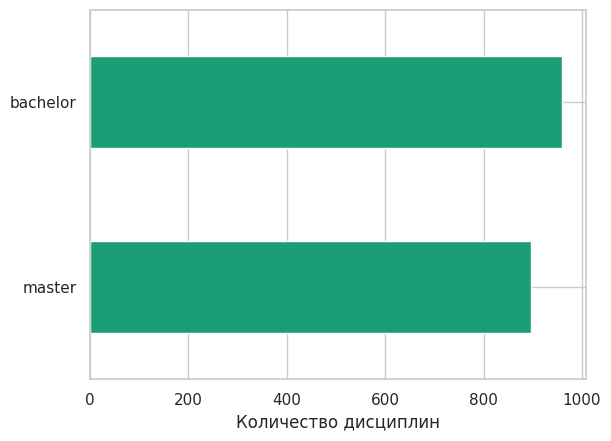

In [ ]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

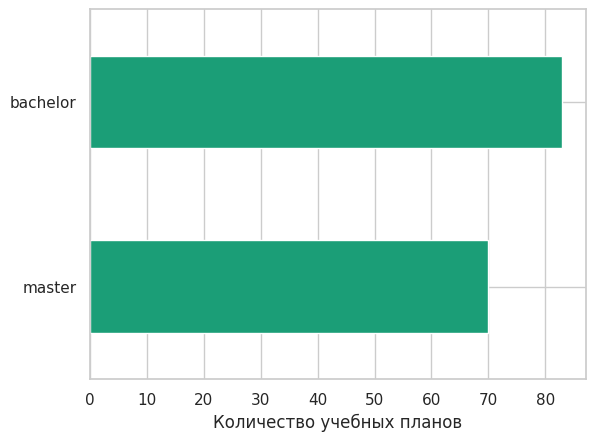

In [ ]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

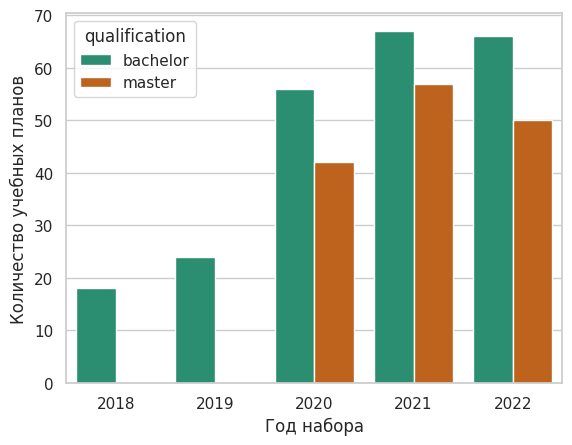

In [ ]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

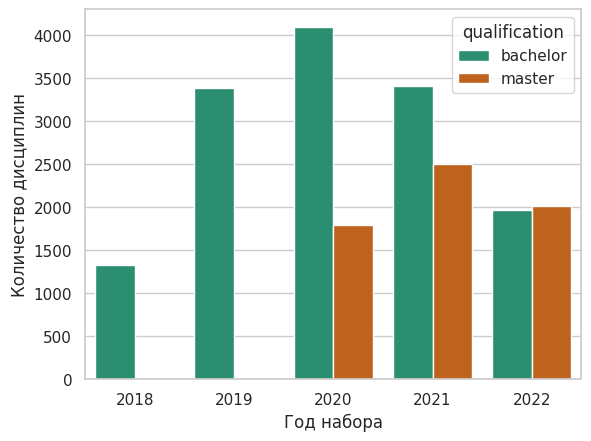

In [ ]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem # для лемматизации


nltk.download('stopwords')
nltk.download('punkt')


m = Mystem()

In [ ]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [ ]:
# обработка содержания

In [ ]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,tokensD
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, -, предоставлять, возможность, ма..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
# обучим на своих данных модель word2vec
# min_count – минимальная частота слова в корпусе
# vector_size – размер вектора для слова
# workers – количество потоков
# window – окно контекста, в которое попадает слово

w2v_model = Word2Vec("ваши данные в формате списка списков токенов", min_count=1, vector_size=300, workers=2, window=10)

In [ ]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [ ]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [ ]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([ 1.0956907e+00,  1.4233451e+00, -3.6250832e+00,  7.7131558e-03,
       -9.0657723e-01,  1.9586326e-01,  1.5344505e+00, -4.6481729e+00,
       -2.2932196e+00,  2.0785673e+00,  8.8172770e-01,  6.2908274e-01,
        2.0827861e+00, -2.7887998e+00, -6.0794735e-01, -8.5561730e-02,
       -4.2222467e-01,  1.1317978e+00, -2.1855886e+00,  1.2654797e+00,
        2.1242716e+00, -5.6782651e-01, -1.3532349e+00,  8.6187094e-01,
       -2.1401079e+00,  2.1238346e+00,  6.2307769e-01,  1.5271190e+00,
        4.0517459e+00, -1.2792484e+00, -8.6358702e-01, -2.5814869e+00,
        3.1027808e+00, -4.4101007e-02,  7.1554214e-01, -7.3155797e-01,
        2.4909494e+00,  2.1296420e+00, -2.6352251e+00,  4.0759635e+00,
       -3.5051262e-01,  1.6979319e-01, -2.1478517e+00, -3.5658009e+00,
        9.1995382e-01,  4.3058926e-01,  3.0395380e-01, -9.3217015e-01,
       -1.8984894e+00, -1.9574289e+00,  3.1552536e+00, -2.8909439e-01,
       -2.8987188e+00, -3.5681505e+00,  2.5078338e-01,  5.7284415e-01,
      

In [ ]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('дикторский', 0.5493224859237671),
 ('подкрепление', 0.5253544449806213),
 ('нейросеть', 0.5114834904670715),
 ('учитель', 0.5069007277488708),
 ('аномалия', 0.5064149498939514),
 ('семантический', 0.5037545561790466),
 ('--', 0.4904346168041229),
 ('crisp-dm', 0.489619642496109),
 ('байесовский', 0.4880848526954651),
 ('сигмоидальный', 0.4741494655609131)]

In [ ]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('статистика', 0.5160747170448303),
 ('панель', 0.4314064085483551),
 ('модальность', 0.424674391746521),
 ('семантический', 0.4163769483566284),
 ('вьювер', 0.40764570236206055),
 ('субд', 0.40717607736587524),
 ('аудиоряд', 0.40293943881988525),
 ('дескриптивный', 0.39662471413612366),
 ('pyldavis', 0.3948679268360138),
 ('данный', 0.39240917563438416)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

In [ ]:
def embed(tokens, w2v_model):
    # ваш код здесь


# пример вектора
embed(df.iloc[0].tokens, w2v_model)

array([-8.25913787e-01,  2.20829457e-01,  5.68561256e-01, -1.05353191e-01,
       -4.24958199e-01,  9.31087673e-01,  5.26823640e-01,  5.26048839e-01,
       -3.92271072e-01, -8.61152768e-01, -2.02900037e-01, -1.42889425e-01,
        2.89558262e-01, -1.15118444e-01,  4.31289613e-01, -6.24137521e-02,
        1.02733362e+00,  7.22694337e-01, -5.24029553e-01,  6.71791255e-01,
       -1.86642423e-01, -4.21679348e-01, -2.14026168e-01,  8.22531223e-01,
       -7.44576395e-01, -1.50631273e+00,  7.78940082e-01, -4.39688116e-01,
        3.49860638e-02, -1.31028402e+00, -3.43445361e-01,  3.35534692e-01,
        4.86041874e-01, -2.31949270e-01, -4.12881315e-01, -6.30208015e-01,
        5.10388970e-01, -5.90875387e-01,  6.99399710e-01,  3.80133718e-01,
        4.69845146e-01,  1.61472544e-01, -1.22378767e+00, -3.99419934e-01,
        3.76914948e-01, -1.02317584e+00,  7.93880880e-01,  1.41685665e-01,
       -5.45069933e-01, -9.20669269e-03,  2.69406229e-01, -2.31460884e-01,
       -2.09053770e-01, -

Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [ ]:
# ваш код здесь

# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,tokensD,embedding,embeddingD
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, -, предоставлять, возможность, ма...","[-0.32808504, -0.16484217, 0.4222597, -0.21925...","[-0.6981015, -0.22522101, 0.27788776, 0.152220..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[-0.4867806, -0.22165154, 0.2573713, 0.9042233...","[0.354802, -0.14068794, -0.2379195, 0.35860807..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.48288378, -0.36358258, 0.26799712, 0.28041...","[-0.5632663, 0.11936013, 0.047031883, -0.18054..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def cosine_similarity(vec1, vec2):
    # ваш код здесь

In [ ]:
# посчитаем косинусное сходство
df["desc_cont_sim"] = df.apply(lambda x: cosine_similarity(x["embedding"], x["embeddingD"]), axis=1)

Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

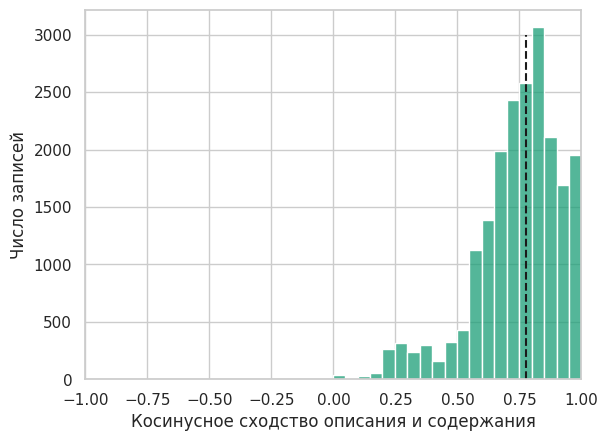

In [ ]:
# ваш код здесь

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [ ]:
# загружаем модель из библиотеки huggingface

from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [ ]:
# ваш код здесь

# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,tokensD,embedding,embeddingD,desc_cont_sim,tokens_text,tokensD_text
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, -, предоставлять, возможность, ма...","[0.1883952, -0.20439114, 0.25310403, -0.139506...","[-0.0076024113, -0.12759566, 0.81738883, 0.547...",0.628,инновационный маркетинг корпоративный финансы ...,цель курс - предоставлять возможность магистра...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[0.17525887, -0.29766303, -0.02009153, 0.81608...","[0.71655047, 0.0473859, -0.46722662, 0.2992459...",0.454,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.35568532, 0.014744152, 0.8801875, 0.582805...","[0.19902095, 0.32024252, 0.5574031, 0.7525074,...",0.704,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

# ваш код здесь

(2221, 1) (2392, 1)


  0%|          | 0/2392 [00:00<?, ?it/s]

Contents vectorized!


  0%|          | 0/2221 [00:00<?, ?it/s]

Description vectorized!


Теперь присоедините полученную таблицу в исходный датафрейм.

In [ ]:
# ваш код здесь

# пример результата объединения
print(df.shape)
df.sample(3, random_state=42)

(20502, 18)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,tokensD,embedding,embeddingD,desc_cont_sim,tokens_text,tokensD_text,bert_embedding,bert_embeddingD
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...,"[инновационный, маркетинг, корпоративный, фина...","[цель, курс, -, предоставлять, возможность, ма...","[0.1883952, -0.20439114, 0.25310403, -0.139506...","[-0.0076024113, -0.12759566, 0.81738883, 0.547...",0.628,инновационный маркетинг корпоративный финансы ...,цель курс - предоставлять возможность магистра...,"[-0.018844858, -0.022349093, 0.018487176, -0.0...","[0.027150301, -0.029449247, 0.022479674, 0.021..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало...","[математический, модель, сигнал, помеха, канал...","[программа, составлять, соответствие, требован...","[0.17525887, -0.29766303, -0.02009153, 0.81608...","[0.71655047, 0.0473859, -0.46722662, 0.2992459...",0.454,математический модель сигнал помеха канал связ...,программа составлять соответствие требование о...,"[-0.013909067, 0.008230449, 0.056430105, -0.00...","[0.028882269, -0.013100322, 0.014136976, -0.00..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....,"[особенность, организация, массовый, мероприят...","[данный, дисциплина, учить, планировать, мероп...","[-0.35568532, 0.014744152, 0.8801875, 0.582805...","[0.19902095, 0.32024252, 0.5574031, 0.7525074,...",0.704,особенность организация массовый мероприятие п...,данный дисциплина учить планировать мероприяти...,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.035781205, -0.0101707755, 0.0017927813, 0.0..."


In [ ]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.bert_embedding[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

In [ ]:
# ваш код здесь

Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

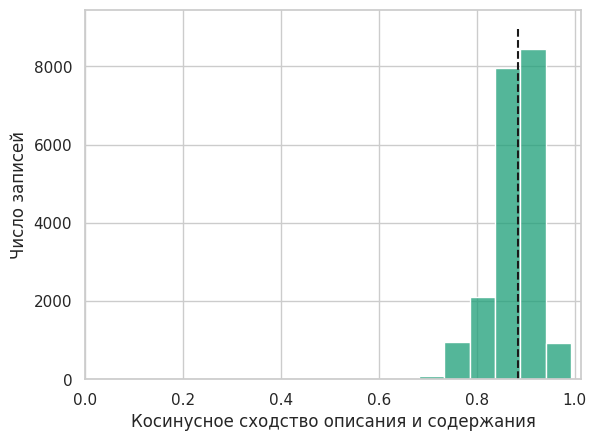

In [ ]:
# ваш код здесь

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

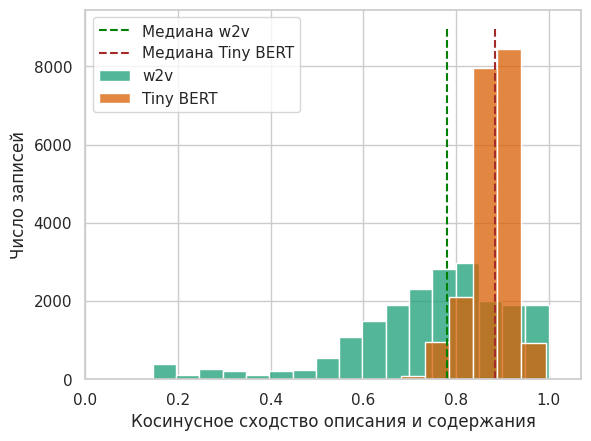

In [ ]:
# ваш код здесь

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

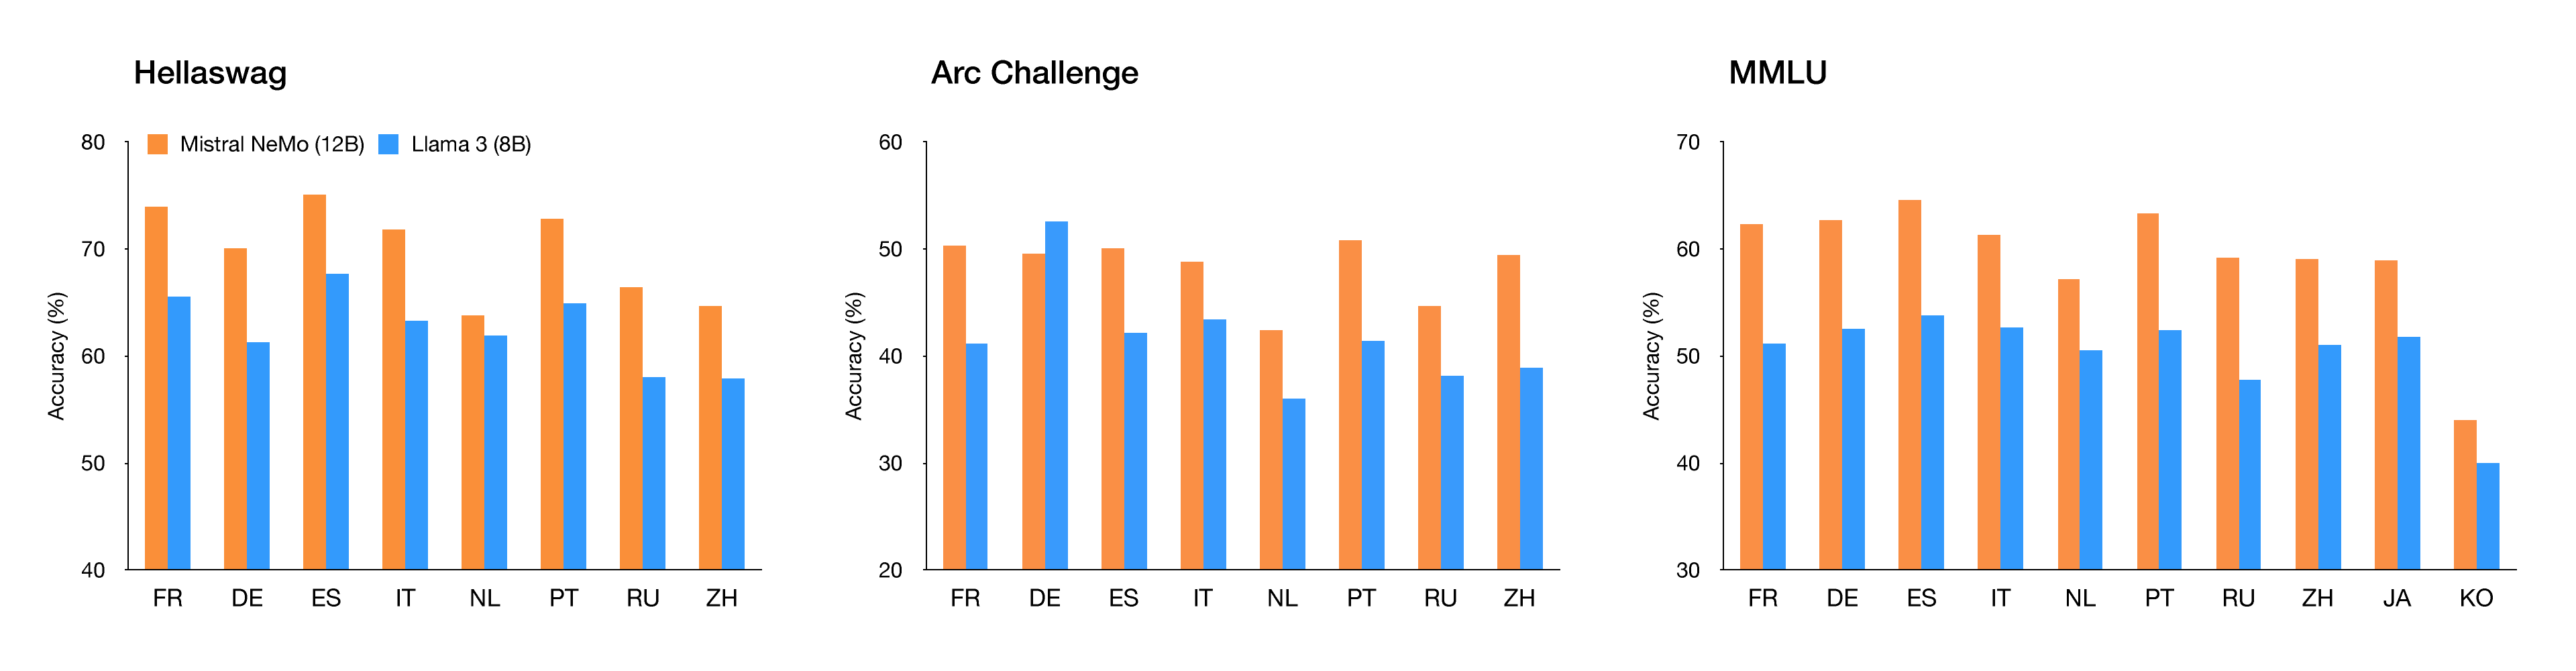

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="hf_XXXXXXXXXXXXXXXXXXXXXX")  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [ ]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

1. Введение в Python и его применение в анализе данных:
   а. Основные концепции и синтаксис Python
   б. Преимущества и области применения Python в анализе данных
   в. Введение в Libraries (библиотеки для анализа данных)

2. Основные типы данных и переменных в Python:
   а. Числовые типы данных
   б. Строковые типы данных
   в. Списки и кортежи
   г. Словари и множества

3. Условные выражения и циклы:
   а. Если-иначе (if-else)
   б. Циклы (for, while)
   в. Ошибки и исключения

4. Введение в NumPy:
   а. Измерение матриц и одномерных массивов
   б. Арithmetic operaciones (арифметические операции)
   в. Agregade functions (функции сложения)

5. Производительность с помощью Pandas:
   а.很显然的数据结构 (явные данные)
   б. Серий и DataFrame
   в. Обработка отсутствующих данных

6. Визуализация данных с помощью Matplotlib и Seaborn:
   а. Matplotlib - основы и функции
   б. Визуализация распределений Seaborn
   в. Картирование многоваловых данных

7. Обработка языковых данных с помощью NLTK:


Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

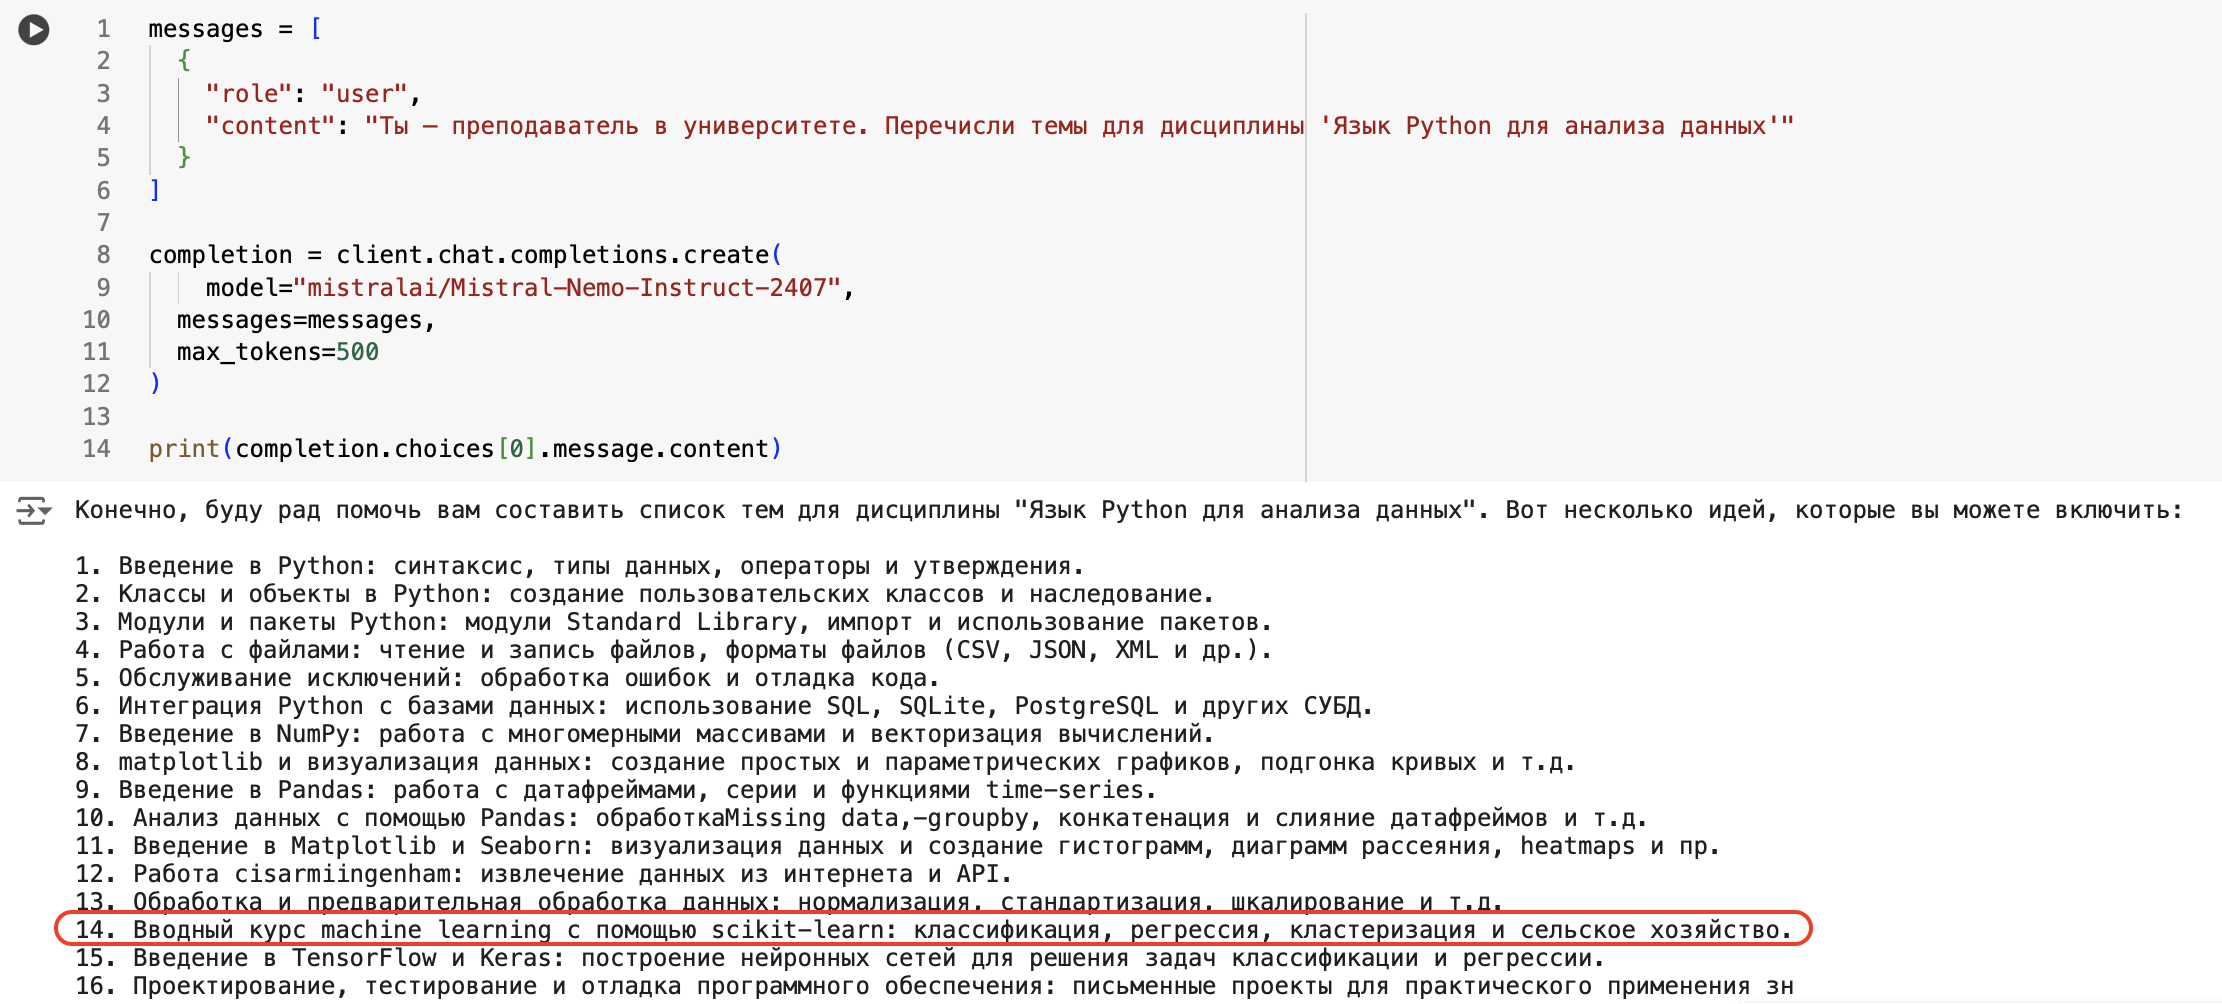

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [ ]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные и операторы.
2. Структуры данных: списки, кортежи, словари, множества.


Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение
2. Математические основы машинного обучения
3. Алгоритмы обучения с учителем
4. Алгоритмы обучения без учителя
5. Нейронные сети и глубокое обучение
6. Выбор и оценка моделей
7. Применение машинного обучения в различных областях
8. Этические аспекты и безопасность в машинном обучении

******************** Машинное обучение: temperature = 0.4 ********************

1. 

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [ ]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [ ]:
def mistral_zero_shot(course, cli, temp):
    # ваш код здесь

Добавьте столбец со сгенерированным содержанием в датафрейм.

In [ ]:
# ваш код здесь

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# ваш код здесь

# пример результата после добавления столбца с генерацией
print(ud_df.shape)
ud_df.sample(3, random_state=42)

(1046, 20)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,tokensD,embedding,embeddingD,desc_cont_sim,tokens_text,tokensD_text,bert_embedding,bert_embeddingD,desc_cont_sim_bert,mistral
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...","[фотоника, взгляд, перспективный, область, исс...","[0.25183907, -0.15061127, 0.14610592, 0.350766...","[0.8150616, 0.10582235, 0.319231, 0.46731356, ...",0.600,введение метод численный электродинамика основ...,фотоника взгляд перспективный область исследов...,"[-0.020190805, -0.0059326044, 0.039794147, -0....","[0.010424809, 0.0003055697, 0.030603899, -0.01...",0.905,1. Введение в моделирование оптических процесс...
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...","[представлять, начало, термодинамика, метод, р...","[0.5842756, 0.58701414, -0.28769168, 0.2190147...","[0.57135826, 0.5636727, -0.20225279, 0.2826224...",0.920,подобие моделирование процесс конвективный теп...,представлять начало термодинамика метод расчет...,"[0.0047562807, 0.010405966, 0.022855595, 0.000...","[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.936,"Конечно, могу вам помочь составить темы и разд..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...","[основной, задача, данный, курс, -, предлагать...","[0.48195675, -0.30692005, 0.2979263, 0.1975168...","[0.43746132, -0.14761502, 0.44876146, 0.886812...",0.707,библиотека архив энциклопедия история big data...,основной задача данный курс - предлагать разли...,"[0.03397241, -0.0092194835, 0.07174899, 0.0086...","[-0.024725934, 0.0033955844, 0.08934714, 0.002...",0.880,Культурные подходы к цифровым практикам - это ...


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [ ]:
# ваш код здесь

In [ ]:
# пример результата обработки
ud_df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,tokens,...,tokens_text,tokensD_text,bert_embedding,bert_embeddingD,desc_cont_sim_bert,mistral,mistral_norm,mistral_w2v,mistral_text,mistral_bert
773,15443,Моделирование оптических процессов,Что такое фотоника? На наш взгляд это очень пе...,6909,Бизнес-информатика,bachelor,2020,ОГНП 7: Фотоника,Введение в методы численной электродинамики. О...,"[введение, метод, численный, электродинамика, ...",...,введение метод численный электродинамика основ...,фотоника взгляд перспективный область исследов...,"[-0.020190805, -0.0059326044, 0.039794147, -0....","[0.010424809, 0.0003055697, 0.030603899, -0.01...",0.905,1. Введение в моделирование оптических процесс...,"[введение, моделирование, оптический, процесс,...","[1.8067466, -0.0066333795, -0.046968356, 0.841...",введение моделирование оптический процесс осно...,"[-0.009672191, 0.024543012, 0.03380115, -0.026..."
280,7593,Техническая термодинамика и теплопередача,"Представлены начала термодинамики, методы расч...",7311,Низкотемпературная техника и энергетика,bachelor,2019,Модуль обязательных дисциплин,Подобие и моделирование процессов конвективног...,"[подобие, моделирование, процесс, конвективный...",...,подобие моделирование процесс конвективный теп...,представлять начало термодинамика метод расчет...,"[0.0047562807, 0.010405966, 0.022855595, 0.000...","[0.0027674034, -0.010737589, 0.019425986, -0.0...",0.936,"Конечно, могу вам помочь составить темы и разд...","[помогать, составлять, тема, раздел, дисциплин...","[-0.059341226, 0.20339549, 0.16487443, 0.08797...",помогать составлять тема раздел дисциплина тех...,"[0.012642328, -0.014231032, 0.0053669694, -0.0..."
629,14936,Культурные подходы к цифровым практикам,Основная задача данного курса - предложить ра...,6987,Инфохимия / Infochemistry,master,2020,Факультативные дисциплины,"Библиотеки, архивы, энциклопедии, история big...","[библиотека, архив, энциклопедия, история, big...",...,библиотека архив энциклопедия история big data...,основной задача данный курс - предлагать разли...,"[0.03397241, -0.0092194835, 0.07174899, 0.0086...","[-0.024725934, 0.0033955844, 0.08934714, 0.002...",0.880,Культурные подходы к цифровым практикам - это ...,"[культурный, подход, цифровой, практика, -, ме...","[0.14267346, -0.1841205, 0.6243267, 1.0093403,...",культурный подход цифровой практика - междисци...,"[0.0061895167, -0.022942208, 0.07796479, 0.010..."


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [ ]:
# ваш код здесь


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `one-shot`.

In [ ]:
# ваш код здесь

#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": """Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.
Ответ:
   Тема 1: Введение в Python для анализа данных
- Обзор Python и его применения в анализе данных
- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)
- Основы синтаксиса Python

Тема 2: Основы анализа данных
- Типы данных и структуры данных в Python
- Обработка и очистка данных
- Работа с большими данными

Тема 3: Анализ данных с помощью NumPy
- Введение в NumPy
- Массивы и векторы
- Операции над массивами
- Функции и методы NumPy

Тема 4: Анализ данных с помощью Pandas
- Введение в Pandas
- Сериалы и ДатаФреймы
- Обработка и манипулирование данными
- Агрегация и групповые операции

Тема 5: Визуализация данных с помощью Matplotlib и Seaborn
- Введение в Matplotlib
- Создание простых графиков
- Настройка стиля и темы
- Введение в Seaborn

Тема 6: Статистический анализ данных
- Введение в статистический анализ
- Работа с вероятностями и распределениями
- Основные статистические тесты

Тема 7: Машинное обучение и анализ данных
- Введение в машинное обучение
- Классификация и регрессия
- Искусственные нейронные сети

Тема 8: Проекты и применение знаний
- Создание проектов по анализу данных
- Презентация результатов анализа
- Обсуждение практического применения знаний в реальных ситуациях

Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8."""
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [ ]:
def mistral_one_shot(course, cli, temp):
    # ваш код здесь

In [ ]:
# ваш код здесь


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [ ]:
# ваш код здесь

## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

In [ ]:
# ваш код здесь

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

In [ ]:
# ваш код здесь

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

In [ ]:
# ваш код здесь

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

In [ ]:
# ваш код здесь

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

In [ ]:
# ваш код здесь

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**